Estratégia 1: CNN Criada do Zero
Esta seção foca na construção, treinamento e avaliação de uma CNN personalizada para o CIFAR-10.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar e pré-processar os dados CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizar os valores de pixel para o intervalo [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Converter rótulos para one-hot encoding (necessário para categorical_crossentropy)
# Se você usar sparse_categorical_crossentropy, não precisa desta linha
# train_labels_one_hot = to_categorical(train_labels, num_classes=10)
# test_labels_one_hot = to_categorical(test_labels, num_classes=10)

print(f"Shape das imagens de treino: {train_images.shape}")
print(f"Shape dos rótulos de treino: {train_labels.shape}") # ou train_labels_one_hot.shape se one-hot

# Construir a CNN do zero
model_cnn_scratch = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 classes para CIFAR-10
])

# Compilar o modelo
model_cnn_scratch.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy', # Use 'categorical_crossentropy' se usar one-hot encoding
                          metrics=['accuracy'])

# Resumo do modelo
model_cnn_scratch.summary()

# Treinar o modelo
history_cnn_scratch = model_cnn_scratch.fit(train_images, train_labels,
                                            epochs=10, # Você pode ajustar o número de épocas
                                            validation_data=(test_images, test_labels))

# Avaliar o modelo
test_loss_cnn_scratch, test_acc_cnn_scratch = model_cnn_scratch.evaluate(test_images, test_labels, verbose=2)
print(f"\nAcurácia da CNN do zero no teste: {test_acc_cnn_scratch * 100:.2f}%")

# Previsões para a matriz de confusão
y_pred_cnn_scratch = np.argmax(model_cnn_scratch.predict(test_images), axis=1)
conf_matrix_cnn_scratch = confusion_matrix(test_labels, y_pred_cnn_scratch)

print("\nMatriz de Confusão (CNN do Zero):")
print(conf_matrix_cnn_scratch)

# Opcional: Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn_scratch, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Classe {i}' for i in range(10)],
            yticklabels=[f'Classe {i}' for i in range(10)])
plt.title('Matriz de Confusão - CNN do Zero')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

# Guarde test_acc_cnn_scratch e conf_matrix_cnn_scratch para o relatório

Estratégia 2: Extrator de Características com Rede Pré-Treinada
Aqui, usaremos uma rede pré-treinada (VGG16 é um bom ponto de partida) para extrair características e, em seguida, treinar um classificador simples (como uma Dense ou SVC) sobre essas características.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNet # Importe MobileNet também
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC # Exemplo de classificador raso
from sklearn.ensemble import RandomForestClassifier # Outro exemplo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar e pré-processar os dados CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# CIFAR-10 tem imagens de 32x32, mas muitas redes pré-treinadas esperam 224x224 ou 150x150.
# Precisamos redimensionar as imagens.
train_images_resized = tf.image.resize(train_images, (32, 32)) # Manter original para MobileNet
test_images_resized = tf.image.resize(test_images, (32, 32))

# Normalizar os valores de pixel para o intervalo [0, 1]
train_images_resized, test_images_resized = train_images_resized / 255.0, test_images_resized / 255.0

# --- Estratégia A: VGG16 como extrator de características ---
# OBS: VGG16 espera entrada de pelo menos 32x32. Se você tentar VGG16 com 32x32, pode ter problemas
# com as camadas de pooling se o output for muito pequeno.
# Para VGG16, é comum redimensionar para 224x224 ou 150x150
# Vamos usar um tamanho que funcione bem para o CIFAR-10, por exemplo, 48x48 se VGG16 não aceitar 32x32
# Ou, para simplificar, vamos manter 32x32 e se VGG16 reclamar, ajustamos.

# Carregar VGG16 pré-treinada no ImageNet (sem as camadas de topo)
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3)) # Pode ser 32x32x3

# Congelar todas as camadas da base_model
for layer in base_model_vgg.layers:
    layer.trainable = False

# Criar um modelo para extrair as características
feature_extractor_vgg = models.Sequential([
    base_model_vgg,
    Flatten() # Achata a saída convolucional
])

# Extrair características dos dados de treino e teste
train_features_vgg = feature_extractor_vgg.predict(train_images_resized)
test_features_vgg = feature_extractor_vgg.predict(test_images_resized)

print(f"Shape das características extraídas (VGG16): {train_features_vgg.shape}")

# Treinar um classificador raso (ex: MLP simples)
classifier_vgg = Sequential([
    Dense(256, activation='relu', input_shape=(train_features_vgg.shape[1],)),
    Dense(10, activation='softmax')
])

classifier_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier_vgg.fit(train_features_vgg, train_labels, epochs=10, validation_split=0.1, verbose=1)

loss_vgg, acc_vgg = classifier_vgg.evaluate(test_features_vgg, test_labels, verbose=2)
print(f"\nAcurácia (VGG16 Feature Extractor + MLP): {acc_vgg * 100:.2f}%")

y_pred_vgg = np.argmax(classifier_vgg.predict(test_features_vgg), axis=1)
conf_matrix_vgg = confusion_matrix(test_labels, y_pred_vgg)
print("\nMatriz de Confusão (VGG16 Feature Extractor + MLP):")
print(conf_matrix_vgg)

# --- Questão a): Trocar para MobileNet ---

# Carregar MobileNet pré-treinada no ImageNet
# MobileNet é mais flexível com tamanhos de entrada, mas 32x32 é pequeno para ImageNet weights.
# É uma boa prática redimensionar para pelo menos 96x96 para MobileNetV2 para obter bons resultados.
# Vamos usar 32x32 para ver o impacto direto da sua pergunta, mas esteja ciente das limitações.

train_images_mobilenet_resized = tf.image.resize(train_images, (96, 96)) # 96x96 é um bom tamanho inicial para MobileNet
test_images_mobilenet_resized = tf.image.resize(test_images, (96, 96))
train_images_mobilenet_resized, test_images_mobilenet_resized = \
    train_images_mobilenet_resized / 255.0, test_images_mobilenet_resized / 255.0


base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(96, 96, 3)) # Ajustado para 96x96x3

for layer in base_model_mobilenet.layers:
    layer.trainable = False

feature_extractor_mobilenet = models.Sequential([
    base_model_mobilenet,
    Flatten() # Ou GlobalAveragePooling2D() para MobileNet
])

train_features_mobilenet = feature_extractor_mobilenet.predict(train_images_mobilenet_resized)
test_features_mobilenet = feature_extractor_mobilenet.predict(test_images_mobilenet_resized)

print(f"\nShape das características extraídas (MobileNet): {train_features_mobilenet.shape}")

classifier_mobilenet = Sequential([
    Dense(256, activation='relu', input_shape=(train_features_mobilenet.shape[1],)),
    Dense(10, activation='softmax')
])

classifier_mobilenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier_mobilenet.fit(train_features_mobilenet, train_labels, epochs=10, validation_split=0.1, verbose=1)

loss_mobilenet, acc_mobilenet = classifier_mobilenet.evaluate(test_features_mobilenet, test_labels, verbose=2)
print(f"\nAcurácia (MobileNet Feature Extractor + MLP): {acc_mobilenet * 100:.2f}%")

y_pred_mobilenet = np.argmax(classifier_mobilenet.predict(test_features_mobilenet), axis=1)
conf_matrix_mobilenet = confusion_matrix(test_labels, y_pred_mobilenet)
print("\nMatriz de Confusão (MobileNet Feature Extractor + MLP):")
print(conf_matrix_mobilenet)

# Guarde os resultados de VGG16 e MobileNet para comparar no relatório.

Estratégia 3: Ajuste Fino (Fine-Tuning) de uma CNN Pré-Treinada
Aqui, usaremos uma rede pré-treinada e treinaremos as últimas camadas convolucionais, juntamente com as camadas densas adicionadas, para se adaptar ao CIFAR-10.


Modelo após adicionar camadas e congelar a base (fase 1 de treinamento):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.4183 - loss: 1.6487 - val_accuracy: 0.5589 - val_loss: 1.2614
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5382 - loss: 1.3094 - val_accuracy: 0.5681 - val_loss: 1.2269
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5627 - loss: 1.2385 - val_accuracy: 0.5817 - val_loss: 1.1866
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5787 - loss: 1.1995 - val_accuracy: 0.5933 - val_loss: 1.1595
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5846 - loss: 1.1794 - val_accuracy: 0.5922 - val_loss: 1.1644

Modelo após descongelar camadas para Fine-Tuning (fase 2 de treinamento):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 13,113,098 (50.02 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step - accuracy: 0.6387 - loss: 1.0328 - val_accuracy: 0.7111 - val_loss: 0.8309
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - accuracy: 0.7454 - loss: 0.7304 - val_accuracy: 0.7457 - val_loss: 0.7318
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.7889 - loss: 0.6074 - val_accuracy: 0.7659 - val_loss: 0.6815
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8241 - loss: 0.4971 - val_accuracy: 0.7658 - val_loss: 0.6812
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8543 - loss: 0.4094 - val_accuracy: 0.7779 - val_loss: 0.6595
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8837 - loss: 0.3284 - val_accuracy: 0.7865 - val_loss: 0.6690
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.9060 - loss: 0.2667 - val_accuracy: 0.7876 - val_loss: 0.6847
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.9233 -

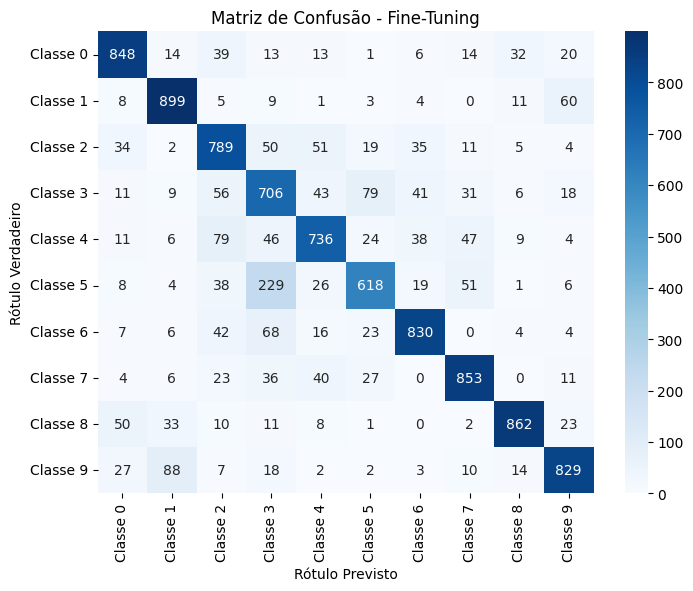

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, datasets
from tensorflow.keras.models import Model # Import the Model class
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar e pré-processar os dados CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Redimensionar e normalizar imagens para o tamanho esperado por VGG16 (ou a rede escolhida)
# Para VGG16, o ideal é 224x224, mas 32x32 pode funcionar com a base sem o topo e camadas customizadas.
# Para o CIFAR-10, 32x32 é o original, então vamos tentar manter isso para ver como a rede lida.
# Se VGG16 reclamar, pode-se redimensionar para 48x48, 64x64, etc.
train_images_resized = tf.image.resize(train_images, (32, 32))
test_images_resized = tf.image.resize(test_images, (32, 32))

train_images_resized, test_images_resized = train_images_resized / 255.0, test_images_resized / 255.0

# Carregar VGG16 pré-treinada no ImageNet (sem as camadas de topo)
base_model_ft = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Congelar todas as camadas da base_model inicialmente
for layer in base_model_ft.layers:
    layer.trainable = False

# Adicionar camadas personalizadas no topo
x = base_model_ft.output
x = layers.Flatten()(x) # Ou GlobalAveragePooling2D() ou GlobalMaxPooling2D()
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x) # Dropout para regularização
predictions = layers.Dense(10, activation='softmax')(x)

model_fine_tuning = Model(inputs=base_model_ft.input, outputs=predictions)

# Compilar o modelo antes do fine-tuning para treinar as novas camadas
model_fine_tuning.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

print("\nModelo após adicionar camadas e congelar a base (fase 1 de treinamento):")
model_fine_tuning.summary()

# Treinar as camadas recém-adicionadas
# Geralmente, algumas épocas são suficientes para as novas camadas se ajustarem
model_fine_tuning.fit(train_images_resized, train_labels,
                      epochs=5, # Poucas épocas na primeira fase
                      validation_data=(test_images_resized, test_labels))

# Descongelar algumas camadas para fine-tuning
# É comum descongelar as últimas camadas convolucionais
# Experimente quantos blocos convolucionais você quer descongelar
# Exemplo: descongelar o último bloco (block5) e camadas densas
for layer in base_model_ft.layers:
    if 'block5' in layer.name or 'block4' in layer.name: # Descongele os blocos que deseja ajustar
        layer.trainable = True
    else:
        layer.trainable = False # Mantenha as outras congeladas

# Recompilar o modelo com uma taxa de aprendizado muito baixa para fine-tuning
# É crucial usar uma taxa de aprendizado baixa para não estragar os pesos pré-treinados
model_fine_tuning.compile(optimizer=optimizers.Adam(learning_rate=1e-5), # Taxa de aprendizado baixa
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

print("\nModelo após descongelar camadas para Fine-Tuning (fase 2 de treinamento):")
model_fine_tuning.summary()

# Continuar o treinamento (fine-tuning)
history_fine_tuning = model_fine_tuning.fit(train_images_resized, train_labels,
                                            epochs=10, # Mais épocas para fine-tuning
                                            validation_data=(test_images_resized, test_labels))

# Avaliar o modelo
test_loss_ft, test_acc_ft = model_fine_tuning.evaluate(test_images_resized, test_labels, verbose=2)
print(f"\nAcurácia do Fine-Tuning no teste: {test_acc_ft * 100:.2f}%")

# Previsões para a matriz de confusão
y_pred_ft = np.argmax(model_fine_tuning.predict(test_images_resized), axis=1)
conf_matrix_ft = confusion_matrix(test_labels, y_pred_ft)

print("\nMatriz de Confusão (Fine-Tuning):")
print(conf_matrix_ft)

# Opcional: Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Classe {i}' for i in range(10)],
            yticklabels=[f'Classe {i}' for i in range(10)])
plt.title('Matriz de Confusão - Fine-Tuning')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

# Guarde test_acc_ft e conf_matrix_ft para o relatório

Estratégia 4: Aumento de Dados (Data Augmentation)
Esta estratégia aplica técnicas de aumento de dados em tempo real durante o treinamento para melhorar a generalização do modelo. As perguntas em aberto também serão abordadas aqui.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,130 (238.79 KB)

 Trainable params: 61,130 (238.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.1345 - loss: 2.2730 - val_accuracy: 0.2621 - val_loss: 1.9937
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.2586 - loss: 1.9884 - val_accuracy: 0.3129 - val_loss: 1.8584
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3199 - loss: 1.8429 - val_accuracy: 0.3770 - val_loss: 1.6992
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3685 - loss: 1.7213 - val_accuracy: 0.4163 - val_loss: 1.6019
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3992 - loss: 1.6434 - val_accuracy: 0.4283 - val_loss: 1.5492
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.4267 - loss: 1.5832 - val_accuracy: 0.4615 - val_loss: 1.4725
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.4464 - loss: 1.5227 - val_accuracy: 0.4870 - val_loss: 1.4199
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4693 - loss: 1.47

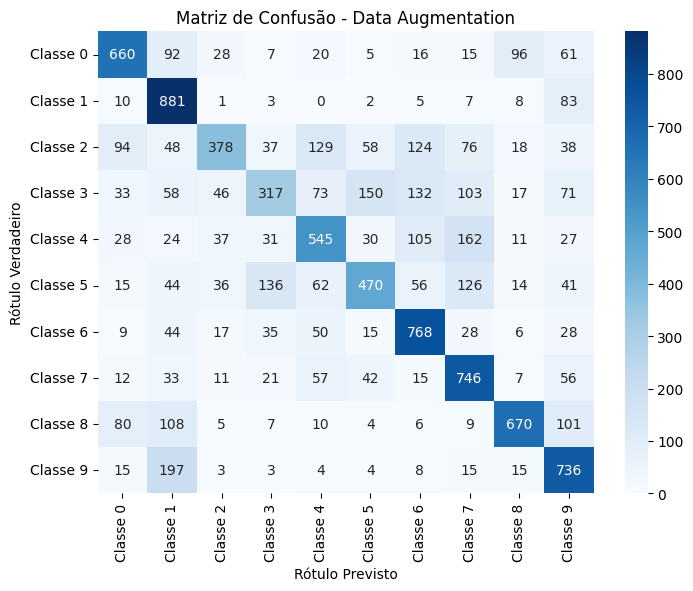

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 # Ou outra rede para fine-tuning
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar e pré-processar os dados CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Redimensionar e normalizar imagens (se necessário para a rede base)
# Para CIFAR-10 com VGG16, 32x32 pode ser usado diretamente
train_images_processed = train_images / 255.0
test_images_processed = test_images / 255.0

# -----------------------------------------------------------
# Modelo base para Data Augmentation (usando a CNN do zero como exemplo, ou VGG16 fine-tuned)
# Para demonstrar, vamos reutilizar a arquitetura da CNN do zero.
# Você pode substituir isso pela arquitetura fine-tuned do VGG16 ou MobileNet.
# -----------------------------------------------------------

model_aug = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.Flatten(), # Questão a: Substituir por GlobalMaxPooling2D()
    layers.GlobalMaxPooling2D(), # Substituição proposta para a Questão a)
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Configurar o gerador de aumento de dados
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotação de até 15 graus
    width_shift_range=0.1,    # Deslocamento horizontal de até 10%
    height_shift_range=0.1,   # Deslocamento vertical de até 10%
    horizontal_flip=True,     # Espelhamento horizontal
    zoom_range=0.1,           # Zoom de até 10%
    fill_mode='nearest'       # Preencher pixels novos com o valor do pixel mais próximo
)

# Preparar o gerador para o conjunto de treinamento
datagen.fit(train_images_processed)

# -----------------------------------------------------------
# Questão b): Substituir o algoritmo otimizador (Adam())
# -----------------------------------------------------------
# Opções de otimizadores: 'adam', optimizers.SGD(learning_rate=0.01, momentum=0.9), optimizers.RMSprop()
# optimizer_choice = 'adam' # Otimizador padrão
optimizer_choice = optimizers.SGD(learning_rate=0.001, momentum=0.9) # Exemplo: SGD com Momentum
# optimizer_choice = optimizers.RMSprop(learning_rate=0.001) # Exemplo: RMSprop


model_aug.compile(optimizer=optimizer_choice, # Otimizador escolhido
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_aug.summary()

# Treinar o modelo com aumento de dados
history_aug = model_aug.fit(datagen.flow(train_images_processed, train_labels, batch_size=32),
                            epochs=20, # Pode aumentar as épocas para ver o impacto total
                            validation_data=(test_images_processed, test_labels))

# Avaliar o modelo
test_loss_aug, test_acc_aug = model_aug.evaluate(test_images_processed, test_labels, verbose=2)
print(f"\nAcurácia do modelo com Data Augmentation no teste: {test_acc_aug * 100:.2f}%")

# Previsões para a matriz de confusão
y_pred_aug = np.argmax(model_aug.predict(test_images_processed), axis=1)
conf_matrix_aug = confusion_matrix(test_labels, y_pred_aug)

print("\nMatriz de Confusão (Data Augmentation):")
print(conf_matrix_aug)

# Opcional: Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Classe {i}' for i in range(10)],
            yticklabels=[f'Classe {i}' for i in range(10)])
plt.title('Matriz de Confusão - Data Augmentation')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

